In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Data loading and inspection 

In [3]:
LABELS = './labels.csv'
TRAIN = Path('./train')

In [4]:
# doc(untar_data)

In [5]:
# untar_data('https://www.kaggle.com/c/7327/download-all')

In [4]:
data = ImageDataBunch.from_csv(path = TRAIN, csv_labels = LABELS, suffix='.jpg', 
                               ds_tfms=get_transforms(do_flip=False), size = 299, bs=48)

data.normalize(imagenet_stats)

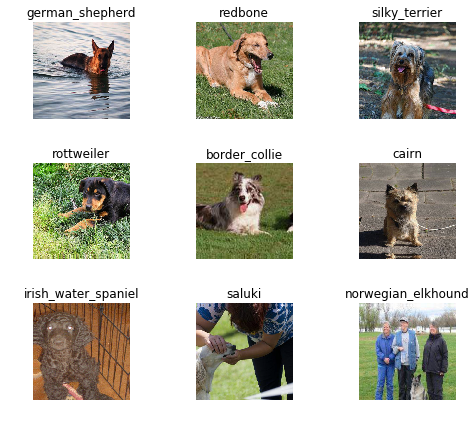

In [5]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
data.tfms

[]

## Basic Modeling

In [57]:
# learn = ConvLearner(data, models.resnet152, metrics=error_rate) ## best arch
learn = ConvLearner(data, models.resnet34, metrics = error_rate)

In [10]:
learn.lr_find()

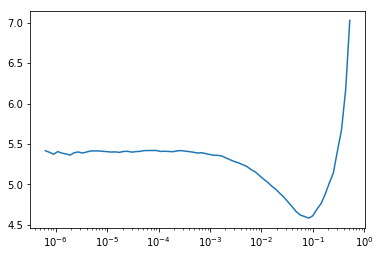

In [11]:
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(4)

Total time: 03:55
epoch  train loss  valid loss  error_rate
1      1.490014    0.715731    0.228224    (00:58)
2      0.893936    0.642587    0.198540    (00:59)
3      0.671070    0.487172    0.151825    (00:58)
4      0.538710    0.476700    0.157178    (00:58)



In [59]:
preds = learn.TTA()

Total time: 01:46



In [22]:
preds[0].size(), preds[1].size()

(torch.Size([2055, 120]), torch.Size([2055]))

In [49]:
np.argmax(np.array(preds[0][0]))

0

In [32]:
Tensor(data.valid_ds.ds.y)

tensor([ 0.,  5.,  6.,  ..., 63., 93., 63.])

In [45]:
np.array(preds[1])[5]

28

In [60]:
wrong = 0
for i in range(len(data.valid_ds.ds.y)):
#     print(np.array(preds[1])[i] - np.argmax(np.array(preds[0][i])))
    if np.array(preds[1])[i] - np.argmax(np.array(preds[0][i])) != 0:
        wrong +=1
    

In [61]:
wrong/2055

0.15085158150851583

In [23]:
learn.fit_one_cycle(4)

Total time: 02:38
epoch  train loss  valid loss  error_rate
1      0.625693    0.609660    0.191233    (00:38)
2      0.722683    0.587836    0.185453    (00:40)
3      0.582584    0.550254    0.168593    (00:39)
4      0.428967    0.515933    0.159923    (00:40)



In [ ]:
learn.recorder.plot_metrics()

In [ ]:
imagenet_stats

In [ ]:
learn.path

In [ ]:
learn.model_dir

In [24]:
learn.save('stage-1-2')

In [ ]:
learn.load('stage-1')

## Fine Tuning 

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 01:22
epoch  train loss  valid loss  error_rate
1      0.414235    0.521262    0.163776    (00:40)
2      0.396423    0.513837    0.161368    (00:41)



Fine tuning does not seem to improve the results

### Resnet 50

In [10]:
learn50 = ConvLearner(data, models.resnet50, metrics=error_rate)

In [11]:
learn50.fit_one_cycle(5)

Total time: 05:57
epoch  train loss  valid loss  error_rate
1      1.349787    0.598409    0.180887    (01:18)
2      0.819082    0.587443    0.180400    (01:09)
3      0.564021    0.499394    0.153584    (01:09)
4      0.404472    0.407447    0.124330    (01:09)
5      0.286351    0.394981    0.116529    (01:09)



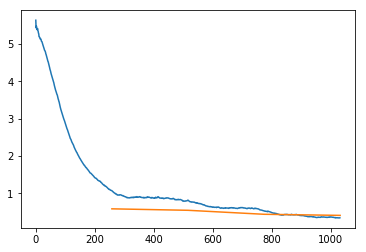

In [17]:
learn50.recorder.plot_losses()

In [12]:
learn50.save('learn50-1')

## Fine Tuning with resnet50

In [18]:
learn50.lr_find()

In [13]:
learn50.unfreeze()

In [22]:
learn50.lr_find()

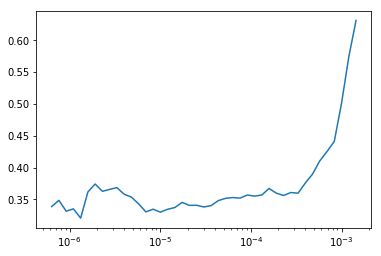

In [23]:
learn50.recorder.plot()

In [15]:
learn50.load('learn50-1')

In [28]:
learn50.unfreeze()

In [ ]:
learn50.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3))

resnet50 improves the accuracy, let's try resnet101

In [29]:
learn101 = ConvLearner(data, models.resnet101, metrics=error_rate)
learn101.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/jupyter/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:11<00:00, 14903701.80it/s]


Total time: 04:17
epoch  train loss  valid loss  error_rate
1      1.195973    0.615462    0.187861    (01:03)
2      0.783284    0.550797    0.166667    (01:04)
3      0.494281    0.402147    0.127168    (01:04)
4      0.338552    0.370273    0.115607    (01:04)



### resnet50 with image size 350

In [4]:
data350 = ImageDataBunch.from_csv(path = TRAIN, csv_labels = LABELS, suffix='.jpg', 
                               ds_tfms=get_transforms(), size = 350, bs=32)

In [5]:
learn50 = ConvLearner(data350, arch=models.resnet50, metrics=error_rate)

In [6]:
learn50.fit_one_cycle(4)

Total time: 06:11
epoch  train loss  valid loss  error_rate
1      1.122028    0.604560    0.175447    (01:39)
2      0.848676    0.538228    0.157058    (01:30)
3      0.539373    0.422303    0.130716    (01:30)
4      0.355977    0.390277    0.127734    (01:30)



error rate with image size 350 is about 1% lower than with image size 224

In [10]:
learn50.save('50stage-1')

In [7]:
learn50.lr_find()

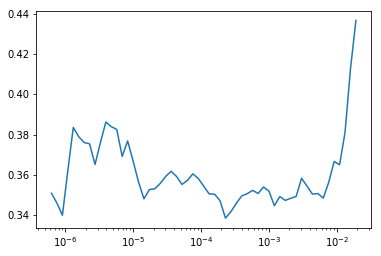

In [9]:
learn50.recorder.plot()

In [11]:
learn50.unfreeze()
learn50.lr_find()

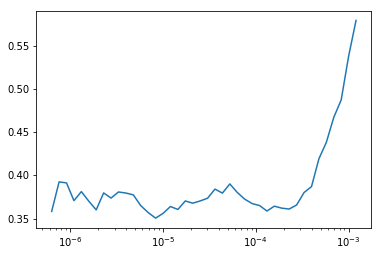

In [12]:
learn50.recorder.plot()

In [13]:
learn50.unfreeze()
learn50.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 03:52
epoch  train loss  valid loss  error_rate
1      0.322158    0.389669    0.121769    (01:56)
2      0.304225    0.384313    0.120278    (01:56)



In [ ]:
here, fine tuning improves the error rate from 0.127 to 0.12!

## clean resnet50 test

image size for resnet50 was 299 in the lesson

In [15]:
data299 = ImageDataBunch.from_csv(path = TRAIN, csv_labels = LABELS, suffix='.jpg', 
                               ds_tfms=get_transforms(), size = 299, bs=32)

In [21]:
learn50 = ConvLearner(data299, arch=models.resnet50, metrics=error_rate)

In [18]:
learn50.lr_find()

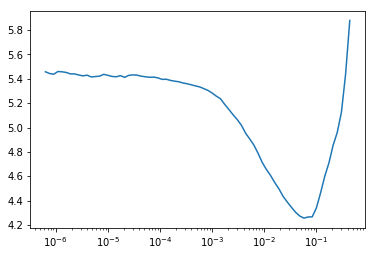

In [19]:
learn50.recorder.plot()

the default max_lr value for fit_one_cycle is slice(None, 0.003, None), let's try to maximum value a little bit larger

In [20]:
learn50.fit_one_cycle(4, max_lr=slice(None, 0.01, None))

Total time: 04:49
epoch  train loss  valid loss  error_rate
1      1.359853    1.155042    0.318932    (01:16)
2      1.349905    0.966638    0.279126    (01:11)
3      0.848420    0.594517    0.177670    (01:10)
4      0.598230    0.560453    0.157282    (01:10)



In [22]:
learn50.fit_one_cycle(4)

Total time: 04:43
epoch  train loss  valid loss  error_rate
1      1.179046    0.585791    0.177670    (01:10)
2      0.848083    0.543999    0.168932    (01:11)
3      0.667626    0.464064    0.141262    (01:11)
4      0.454063    0.429911    0.132039    (01:10)



In [24]:
learn50.unfreeze()
learn50.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 03:00
epoch  train loss  valid loss  error_rate
1      0.363226    0.447933    0.131068    (01:30)
2      0.313902    0.435658    0.132524    (01:30)



## Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.